In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression, Ridge
import torch
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import collections


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/kaggle/input/frauddetection/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


We observe that we have 3 categorical columns which we need to transform to numeric ones.

Namely - 
* __type__
* __nameOrig__
* __nameDest__

There are 0 null values present in the dataset.


<Axes: >

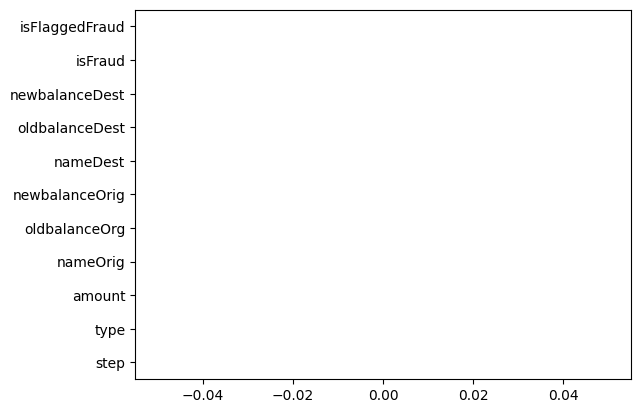

In [3]:
print(f'There are {df.isnull().sum().max()} null values present in the dataset.')
df.isnull().sum().plot(kind = 'barh')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset


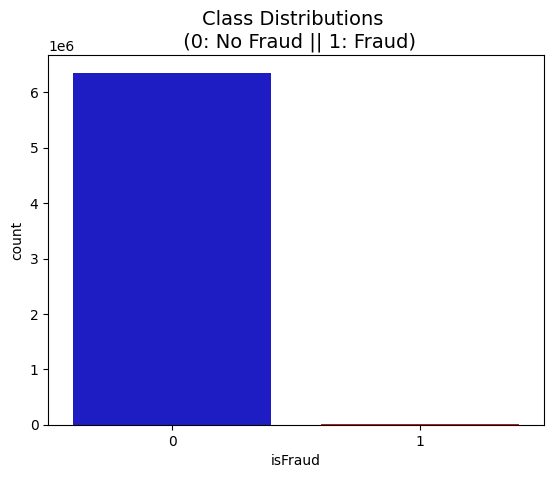

In [5]:
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

colors = ["#0101DF", "#DF0101"]
sns.countplot(x ='isFraud', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

The dataset we have is highly skewed. We need to balance it accordingly for proper results.

In [4]:
#Checking the numner of unique values in the categorical columns 
print(f"'type' has {df['type'].nunique()} unique values.")
print(f"'nameOrig' has {df['nameOrig'].nunique()} unique values.")
print(f"'nameDest' has {df['nameDest'].nunique()} unique values.")

'type' has 5 unique values.
'nameOrig' has 6353307 unique values.
'nameDest' has 2722362 unique values.


While **type** has a small number of values which we can conveniently one hot encode, **nameOrig** and **nameDest** have a lot of unique values. One hot encoding will lead to dimensionality explosion. We need to work differently with these 2 columns.

We could use *LabelEncoder* on them but that would introduce some sense of ordinality which we don't want. An approach we can take is replace these categorical columns with their some of their statistical counterparts. A few common yet useful ones would be to compute the count of transactions corresponding to the column value, compute the mean of the transactions completed by that value/id and so on. 

In [19]:
df['nameOrig_tx_count'] = df.groupby('nameOrig')['amount'].transform('count')
df['nameOrig_mean_amount'] = df.groupby('nameOrig')['amount'].transform('mean')
df['nameOrig_fraud_rate'] = df.groupby('nameOrig')['isFraud'].transform('mean')

df['nameDest_tx_count'] = df.groupby('nameDest')['amount'].transform('count')
df['nameDest_mean_amount'] = df.groupby('nameDest')['amount'].transform('mean')
df['nameDest_fraud_rate'] = df.groupby('nameDest')['isFraud'].transform('mean')

In [20]:
#Feature engineering a few more features which could be useful 

df['amount_to_avg_ratio'] = df['amount'] / df['nameOrig_mean_amount']
df['amount_to_avg_ratio'] = df['amount_to_avg_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0) #edge case : handling div by 0

threshold = 0.01
df['is_account_emptied'] = ((df['newbalanceOrig'] <= threshold * df['oldbalanceOrg']) | 
                            (df['newbalanceOrig'] == 0)).astype(int)

df['customer_amount_std'] = df.groupby('nameOrig')['amount'].transform('std')

epsilon = 1e-8  
df['customer_amount_std'] = df['customer_amount_std'].replace(0, epsilon)
df['amount_zscore'] = (df['amount'] - df['nameOrig_mean_amount']) / df['customer_amount_std']
df['amount_zscore'] = df['amount_zscore'].replace([np.inf, -np.inf], np.nan)
df['amount_zscore'] = df['amount_zscore'].fillna(0)


df.drop(['customer_amount_std'], axis=1, inplace=True)

A description of the newly engineered features - 

* **nameOrig_tx_count** - count of transactions corresponding to each customer in the **nameOrig** column.

* **nameOrig_mean_amount** - the average transaction made by each customer.

* **nameOrig_fraud_rate** - the mean value of the `isFraud` column for each customer, thereby computing the fraud rate.

* **amount_to_avg_ratio** - This computes the relative size of each transaction in comparison with the average transaction made by that customer.


* **is_account_emptied** - This checks if the current transaction empties the account or if it brings down the account value beyond a certain threshold (a hyperparameter). The threshold is set to 1% of the original amount.

* **amount_zscore** - This new feature can be useful for understanding how the transaction amount compares to the average transaction amount for each nameOrig in terms of standard deviations


However, the usefulness of these features is yet to be determined.

In [21]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrig_tx_count,nameOrig_mean_amount,nameOrig_fraud_rate,nameDest_tx_count,nameDest_mean_amount,nameDest_fraud_rate,amount_to_avg_ratio,is_account_emptied,amount_zscore
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,1.002932e+00,1.798619e+05,1.290820e-03,1.119224e+01,1.798619e+05,1.290820e-03,9.999975e-01,5.679197e-01,-1.811920e-19
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,5.420031e-02,6.032581e+05,3.587414e-02,1.239544e+01,2.934691e+05,2.408110e-02,3.769013e-02,4.953655e-01,3.825840e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.149463e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.342510e+04,0.000000e+00,1.000000e+00,1.680838e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,1.000000e+00,7.506466e+04,0.000000e+00,7.000000e+00,1.583857e+05,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.000000e+00,2.086761e+05,0.000000e+00,1.700000e+01,2.449600e+05,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,3.000000e+00,9.244552e+07,1.000000e+00,1.130000e+02,2.070695e+07,1.000000e+00,2.777840e+00,1.000000e+00,1.154678e+00


In [22]:
print(df['nameOrig_tx_count'].value_counts())
print(df['nameOrig_fraud_rate'].value_counts())

print(df['nameDest_tx_count'].value_counts())
print(df['nameDest_fraud_rate'].value_counts())

df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

nameOrig_tx_count
1    6344009
2      18566
3         45
Name: count, dtype: int64
nameOrig_fraud_rate
0.0    6354379
1.0       8185
0.5         56
Name: count, dtype: int64
nameDest_tx_count
1     2262704
5      184105
6      182496
7      180649
4      180460
       ...   
91         91
88         88
85         85
83         83
78         78
Name: count, Length: 101, dtype: int64
nameDest_fraud_rate
0.000000    6296972
1.000000       2681
0.066667       2445
0.052632       2109
0.100000       2100
             ...   
0.095238         21
0.117647         17
0.133333         15
0.400000          5
0.666667          3
Name: count, Length: 82, dtype: int64


A small observation, we can observe that the fraud rate varies significantly across the customers, which indicates that some customers have a greater propensity of being a prey to a fraud.

In [23]:
onehot = OneHotEncoder(sparse_output=False)
df = pd.concat([df, pd.DataFrame(onehot.fit_transform(df[['type']]), columns=onehot.get_feature_names_out(['type']))], axis=1)
df.drop('type', axis=1, inplace=True)

df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrig_tx_count,nameOrig_mean_amount,...,nameDest_mean_amount,nameDest_fraud_rate,amount_to_avg_ratio,is_account_emptied,amount_zscore,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,1,9839.64,...,9.839640e+03,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,1,1864.28,...,1.864280e+03,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,1,181.00,...,2.255178e+05,0.022727,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,1,181.00,...,4.394442e+05,0.024390,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,1,11668.14,...,1.166814e+04,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,1,339682.13,...,3.323914e+05,0.500000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,1,6311409.28,...,6.311409e+06,1.000000,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,1,6311409.28,...,2.212471e+06,0.333333,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,1,850002.52,...,8.500025e+05,1.000000,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
print(df.corr()['isFraud']) 

step                    0.031578
amount                  0.076688
oldbalanceOrg           0.010154
newbalanceOrig         -0.008148
oldbalanceDest         -0.005885
newbalanceDest          0.000535
isFraud                 1.000000
isFlaggedFraud          0.044109
nameOrig_tx_count       0.000316
nameOrig_mean_amount    0.076671
nameOrig_fraud_rate     0.999146
nameDest_tx_count      -0.008982
nameDest_mean_amount    0.079746
nameDest_fraud_rate     0.670693
amount_to_avg_ratio    -0.000180
is_account_emptied      0.029944
amount_zscore           0.001294
type_CASH_IN           -0.019089
type_CASH_OUT           0.011256
type_DEBIT             -0.002911
type_PAYMENT           -0.025697
type_TRANSFER           0.053869
Name: isFraud, dtype: float64


<Axes: >

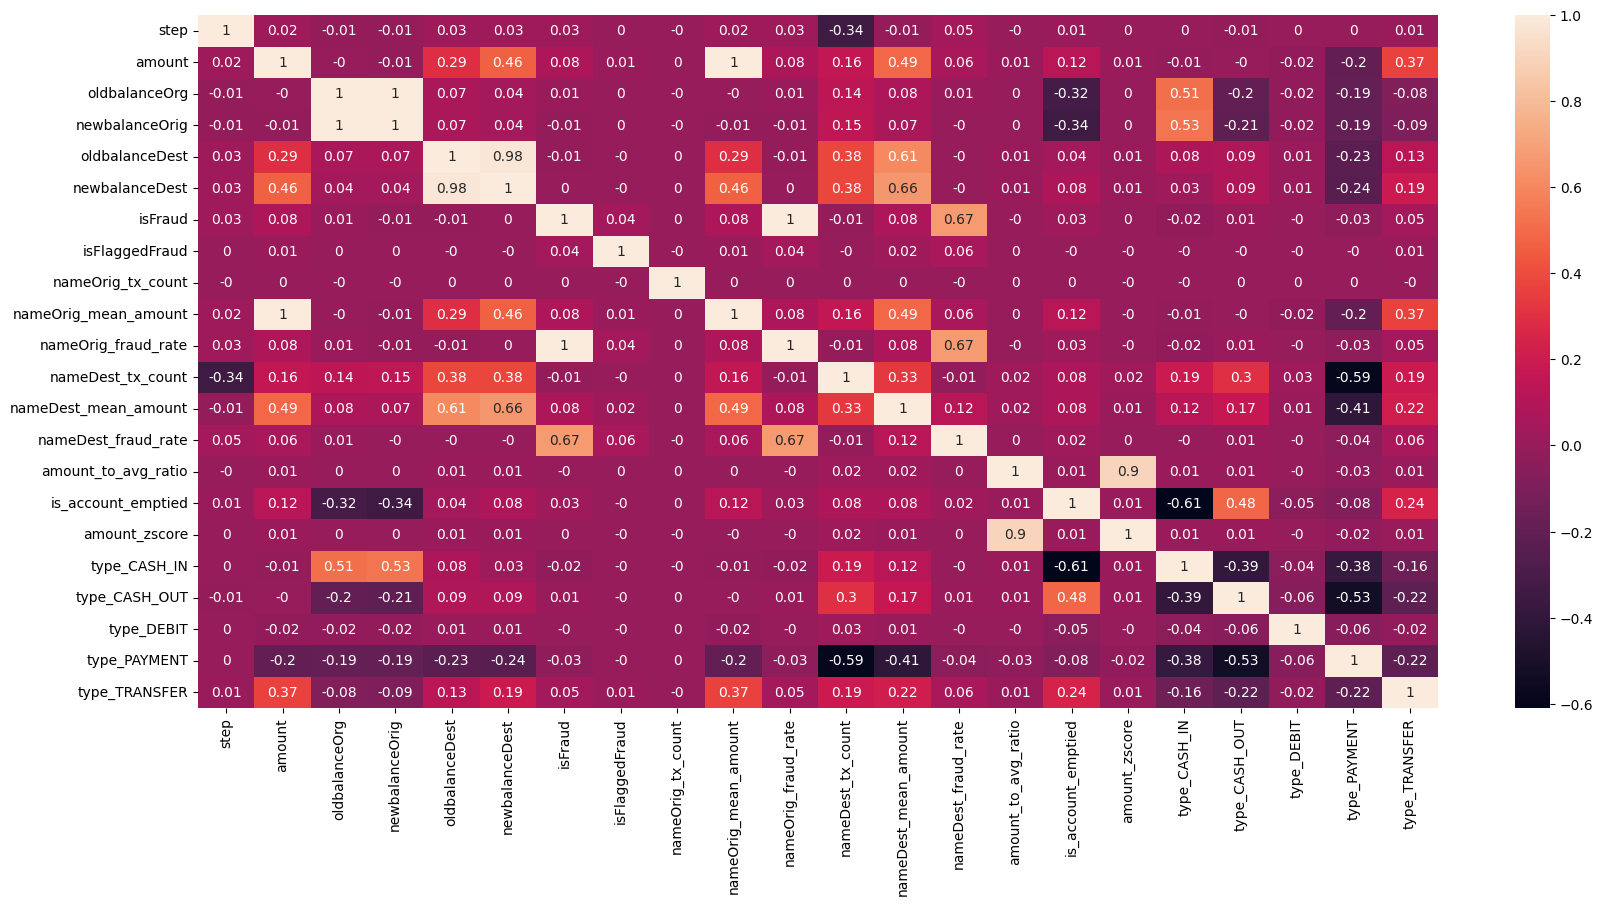

In [10]:
correlation = df.corr().round(2)
plt.figure(figsize = (20,9))
sns.heatmap(correlation, annot = True)

Looks like we are going to encounter some multicollinearity issues from the plot above, let's confirm our doubts by computing the **Variance Inflation Factor** for each feature (except the target feature).

In [14]:
features = df.drop("isFraud", axis=1)
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif_data["Feature"] = features.columns
vif_data

,VIF,Feature
0,4.935593,step
1,610.576906,amount
2,742.157121,oldbalanceOrg
3,765.250505,newbalanceOrig
4,75.991470,oldbalanceDest
5,89.263229,newbalanceDest
6,1.005273,isFlaggedFraud
7,343.405339,nameOrig_tx_count
8,607.171399,nameOrig_mean_amount
9,2.028646,nameOrig_fraud_rate


We observe that most of the new features that we have engineered have a VIF range <5, which indicates that the features could be of some relevance to the model. However, that can be concluded on only after we observe the feature importance of the models.

In [ ]:
# #Addressing multicollinearity with Ridge Regression
# USE THIS AFTER ALL OF THE PREPROCESSING


# X = df.drop("isFraud", axis=1)
# y = df["isFraud"]

# ridge = Ridge(alpha=1.0)
# ridge.fit(X, y)
# coefs = pd.DataFrame({
#     'Feature': X.columns,
#     'Coefficient': ridge.coef_
# })

# plt.figure(figsize=(10, 5))
# sns.barplot(data=coefs, x='Feature', y='Coefficient', palette='viridis')
# plt.title('Ridge Regression Coefficients')
# plt.ylabel('Coefficient Value')
# plt.xticks(rotation=45)  
# plt.tight_layout()
# plt.show()

In [24]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [25]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameOrig_tx_count,nameOrig_mean_amount,nameOrig_fraud_rate,...,nameDest_mean_amount,nameDest_fraud_rate,amount_to_avg_ratio,is_account_emptied,amount_zscore,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,1,9839.64,0.0,...,9.839640e+03,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,1,1864.28,0.0,...,1.864280e+03,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,0,1,181.00,1.0,...,2.255178e+05,0.022727,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.00,0.00,21182.00,0.00,0,1,181.00,1.0,...,4.394442e+05,0.024390,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,1,11668.14,0.0,...,1.166814e+04,0.000000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,0,1,339682.13,1.0,...,3.323914e+05,0.500000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,0,1,6311409.28,1.0,...,6.311409e+06,1.000000,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,1,6311409.28,1.0,...,2.212471e+06,0.333333,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,0,1,850002.52,1.0,...,8.500025e+05,1.000000,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0


With such a large corpus of data (about 6.3 million data points), removing some outliers can have a two fold effect - 

* Improve the stability of training.

* Reduce the size of the data.

We'll be using **Isolation Forest** to take care of the outliers in the data.

In [26]:
from sklearn.ensemble import IsolationForest


iso = IsolationForest(random_state=42)
yhat = iso.fit_predict(X)

mask = yhat != -1
X = X[mask]
# X_outliers = X[~mask]
y = y[mask]

In [27]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameOrig_tx_count,nameOrig_mean_amount,nameOrig_fraud_rate,...,nameDest_mean_amount,nameDest_fraud_rate,amount_to_avg_ratio,is_account_emptied,amount_zscore,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.00,0.00,0,1,9839.64,0.0,...,9839.640000,0.00000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.0,19384.72,0.00,0.00,0,1,1864.28,0.0,...,1864.280000,0.00000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,181.00,181.0,0.00,21182.00,0.00,0,1,181.00,1.0,...,439444.208049,0.02439,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,29885.86,0.00,0.00,0,1,11668.14,0.0,...,11668.140000,0.00000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
5,1,7817.71,53860.0,46042.29,0.00,0.00,0,1,7817.71,0.0,...,7817.710000,0.00000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362317,718,317177.48,170.0,0.00,345042.13,662219.61,0,1,317177.48,0.0,...,228733.587143,0.00000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362318,718,4109.57,5521.0,1411.43,0.00,0.00,0,1,4109.57,0.0,...,4109.570000,0.00000,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
6362320,718,159188.22,3859.0,0.00,0.00,159188.22,0,1,159188.22,0.0,...,159188.220000,0.00000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0
6362321,718,186273.84,168046.0,0.00,24893.67,211167.51,0,1,186273.84,0.0,...,105583.755000,0.00000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0


We observe that ~600k points have been removed.

In [32]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

subset_size = 50000
subset_indices = np.random.choice(len(original_Xtrain), size=subset_size, replace=False)
X_subset = original_Xtrain.iloc[subset_indices]
y_subset = original_ytrain.iloc[subset_indices]

rf_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

for train_index, val_index in sss.split(X_subset, y_subset):
    X_train, X_val = X_subset.iloc[train_index], X_subset.iloc[val_index]
    y_train, y_val = y_subset.iloc[train_index], y_subset.iloc[val_index]
    
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', RobustScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    
    search = RandomizedSearchCV(pipeline, param_distributions=rf_params, n_iter=5, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    accuracy_lst.append(accuracy_score(y_val, y_pred))
    precision_lst.append(precision_score(y_val, y_pred))
    recall_lst.append(recall_score(y_val, y_pred))
    f1_lst.append(f1_score(y_val, y_pred))
    auc_lst.append(roc_auc_score(y_val, y_pred))

print(f"Cross-Validation Accuracy: {np.mean(accuracy_lst):.4f}")
print(f"Cross-Validation Precision: {np.mean(precision_lst):.4f}")
print(f"Cross-Validation Recall: {np.mean(recall_lst):.4f}")
print(f"Cross-Validation F1 Score: {np.mean(f1_lst):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_lst):.4f}")

X_subset_scaled = RobustScaler().fit_transform(X_subset)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_subset_scaled, y_subset)

best_model.fit(X_resampled, y_resampled)
X_test_scaled = RobustScaler().fit_transform(original_Xtest)
y_test_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(original_ytest, y_test_pred)
test_precision = precision_score(original_ytest, y_test_pred)
test_recall = recall_score(original_ytest, y_test_pred)
test_f1 = f1_score(original_ytest, y_test_pred)
test_auc = roc_auc_score(original_ytest, y_test_pred)

print('-' * 100)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Cross-Validation Accuracy: 0.9999
Cross-Validation Precision: 1.0000
Cross-Validation Recall: 0.7000
Cross-Validation F1 Score: 0.8000
Cross-Validation AUC: 0.8500
----------------------------------------------------------------------------------------------------
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 0.9385
Test F1 Score: 0.9683
Test AUC: 0.9692


The above snippet of code is a result of a few hours of failed experimentation. Initially, I had planned to perform a stratified K-fold cross-validation for handful of shallow learning models like *KNN, Logistic Regression, SVC, XGBoost, Random Forests* and compare the results and the evaluation metrics. 

However, I hit a hurdle. Even after eliminating the outliers and the size of the data being brought down to **5.7 million** data points, it was too large for the models to train on, since scikit-learn models don't scale well on a dataset of this size, for that we have the *Apache Spark MLlib* models. However, after spending 4 hours trying to train a Logistic Regression model on the data (Logistic Regression is known for it's speed), I came to the conclusion that i needed to find some other way to get it done.

After spending some time to think out a feasible approach, I came up with the solution of extracting a random subset of the data (random to keep the distribution of the data intact) and train a model on that to have a sense of how well the data is prepared to undergo the modelling pipeline. I decided to proceed with **Random Forest Classifier** since in my experience, Random Forests perform well on moderate dimensional data and provide feature importances as well.

Proceeding with the plan, I created a subset of 50,000 data points and passed it through a pipeline of -

- Upsampling with **SMOTE**
- Scaling with **Robust Scaler**
- training the data on **Random Forest Classifier**

through a *5 fold Cross-validation* in order to look out for any signs of overfitting or discrepancy in any of the folds.

After checking through the Cross-validation, the same pipeline was used for the test data as a final check for the metrics, computing the **Accuracy, Precision, Recall, F1 Score, ROC-AUC** for an all rounded evaluation of the performance on the model predictions.

With decent enough results from the subset of data, I gained the confidence to move forward with the entire dataset.

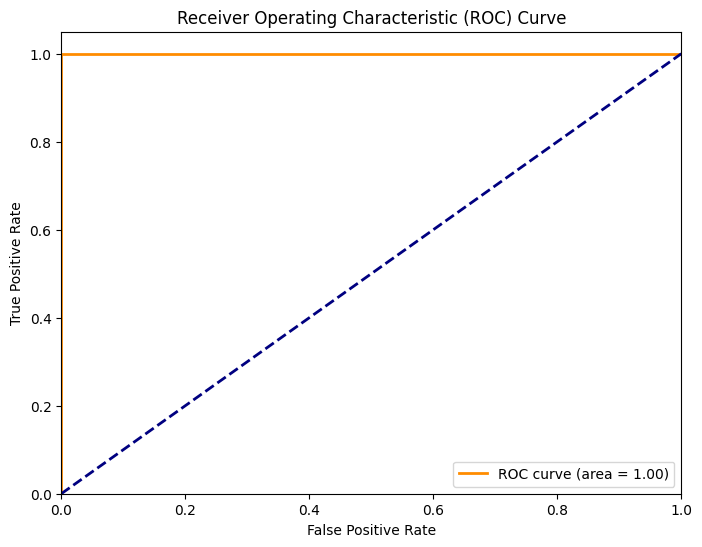

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # Predicted probabilities for class 1

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(original_ytest, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Feature importances:
                 Feature    Importance
0    nameDest_fraud_rate  2.931737e-01
1    nameOrig_fraud_rate  2.893904e-01
2          oldbalanceOrg  1.072537e-01
3          type_CASH_OUT  7.789794e-02
4         newbalanceOrig  4.806788e-02
5   nameOrig_mean_amount  4.255524e-02
6      nameDest_tx_count  3.744647e-02
7         newbalanceDest  2.888300e-02
8                 amount  1.953448e-02
9   nameDest_mean_amount  1.483110e-02
10        oldbalanceDest  1.168421e-02
11          type_CASH_IN  9.870622e-03
12    is_account_emptied  9.824519e-03
13          type_PAYMENT  7.096214e-03
14                  step  2.332434e-03
15         type_TRANSFER  1.566171e-04
16            type_DEBIT  1.394569e-06
17         amount_zscore  1.212388e-08
18     nameOrig_tx_count  0.000000e+00
19        isFlaggedFraud  0.000000e+00
20   amount_to_avg_ratio  0.000000e+00


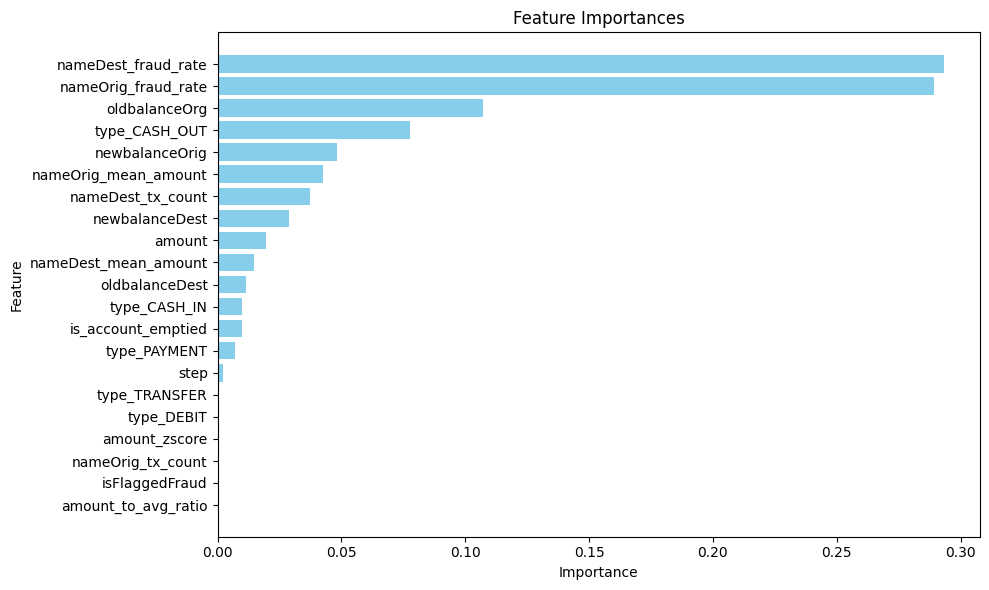

In [34]:
rf_model = best_model.named_steps['rf']
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print("Feature importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

As planned, a detailed plotting of the importance for all the features based on the evaluation of the Random Forest model has been provided.

We observe that the **fraud rate** features which were later engineered came out as the most valuable ones, and this makes sense intuively and proves our prior prediction about this feature holding some value.

Apart from that, the old balance in accounts also stood out as an important evaluating feature, which makes sense as well since the delta between the old balance and the new balance after making the transaction could be a strong indicator of fraud, since people don't usually empty out their entire accounts.

We also observe the few features at the end of the plot which are not contributing much to the modelling. While these features can be removed, it must be done cautiously. In our case, I let the features be since dimensionality inflation is not our current concern.

In [36]:
X_train, X_val, y_train, y_val = train_test_split(original_Xtrain, original_ytrain, test_size = 0.2, random_state = 42)
X_train.shape, X_val.shape, original_Xtest.shape

((3687957, 21), (921990, 21), (1152487, 21))

**Train/val/test** split for a foolproof evalution.

In [37]:

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU is available")
    
def ridge_feature_selection(X, y, alpha=1.0):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    return ridge.coef_

ridge_coef = ridge_feature_selection(X_train, y_train)
selected_features = X_train.columns[np.abs(ridge_coef) > 1e-5]

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = original_Xtest[selected_features]


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_resampled))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, original_ytest))


BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

y_pred_proba = model.predict(test_dataset)
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(original_ytest, y_pred))
print(f"ROC AUC Score: {roc_auc_score(original_ytest, y_pred_proba):.4f}")

2024-07-11 17:06:34.866898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 17:06:34.867052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 17:06:35.003899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available
Epoch 1/2
    86/230471 ━━━━━━━━━━━━━━━━━━━━ 6:52 2ms/step - accuracy: 0.8650 - loss: 0.4742

I0000 00:00:1720717614.952063     227 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230471/230471 ━━━━━━━━━━━━━━━━━━━━ 443s 2ms/step - accuracy: 0.9998 - loss: 0.1818 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/2
230471/230471 ━━━━━━━━━━━━━━━━━━━━ 435s 2ms/step - accuracy: 1.0000 - loss: 8.4142e-05 - val_accuracy: 1.0000 - val_loss: 4.3800e-05 - learning_rate: 0.0010
36016/36016 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 1.0000 - loss: 4.1982e-05
Test accuracy: 1.0000
36016/36016 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1152357
           1       0.81      1.00      0.89       130

    accuracy                           1.00   1152487
   macro avg       0.90      1.00      0.95   1152487
weighted avg       1.00      1.00      1.00   1152487

ROC AUC Score: 1.0000


With a dataset of this size, I decided on using a simple Neural Network as our model. I chose the Keras background since we have already done the bulk of the processing and we just need a high level API to get done with the modelling, involving PyTorch in this case would be inefficient.

Here's an explanation behind the data preprocessing pipeline -

- Using **Ridge Regression** - As we had priorly observed, some of the features of our data was suffering from multicollinearity, and incorporating Ridge regression in the pipeline is a good way to address it. We filtered our data based off the Regression coeffiecients.

- using **SMOTE** for upsampling and balancing our data.

- using **Standard Scaler** as the final preprocessing step to scale our data.

The architecture of the neural net is very simple, we compress the latent space of the data at each step with some Dropout to keep the overfitting in check. The choice for epochs was empirically set after a few iterations and experiments, the callbacks were added for better training.

At the end, we see that we have achieved pretty decent results. The precision for the Fraud predictions is slightly off the bar but we usually do see that in such severely skewed datasets. We can owe the all rounded performance to the extensive data massaging, feature engineering, testing for various stuff and a clean model for training.

---------------------------------------------------------------------------------------------------------------------------------------------------
